In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import random
import matplotlib.pyplot as plt 

In [2]:
# Para reproducibilidad (opcional)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Cargar datos
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Separar validación
x_val = x_train[-5000:]
x_train = x_train[:-5000]

# Parámetros globales
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 128
EPOCHS = 5  # Ajustar según cómputo disponible

print("x_train:", x_train.shape)
print("x_val:  ", x_val.shape)
print("x_test: ", x_test.shape)


x_train: (45000, 32, 32, 3)
x_val:   (5000, 32, 32, 3)
x_test:  (10000, 32, 32, 3)


In [3]:
# Espacios de búsqueda 
ACTIVATIONS = ["relu", "sigmoid", "tanh"]
N_HIDDEN_LAYERS_MIN, N_HIDDEN_LAYERS_MAX = 1, 3
UNITS_MIN, UNITS_MAX = 8, 256
LATENT_DIM_MIN, LATENT_DIM_MAX = 4, 32
LEARNING_RATE_MIN, LEARNING_RATE_MAX = 1e-4, 1e-1

def random_individual():
    n_hidden_layers = random.randint(N_HIDDEN_LAYERS_MIN, N_HIDDEN_LAYERS_MAX)
    units_per_layer = [
        random.randint(UNITS_MIN, UNITS_MAX) 
        for _ in range(n_hidden_layers)
    ]
    latent_dim = random.randint(LATENT_DIM_MIN, LATENT_DIM_MAX)
    activation = random.choice(ACTIVATIONS)
    # Log-uniform sampling para tasa de aprendizaje 
    learning_rate = 10 ** random.uniform(np.log10(LEARNING_RATE_MIN), np.log10(LEARNING_RATE_MAX))
    
    return {
        'n_hidden_layers': n_hidden_layers,
        'units_per_layer': units_per_layer,
        'latent_dim': latent_dim,
        'activation': activation,
        'learning_rate': learning_rate
    }


In [4]:
def build_and_train_autoencoder(hparams):
    # 1. Construir modelo
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = layers.Flatten()(inputs)
    
    # Capas ocultas
    for units in hparams['units_per_layer']:
        x = layers.Dense(units, activation=hparams['activation'])(x)
    
    # Bottleneck (capa latente)
    x = layers.Dense(hparams['latent_dim'], activation=hparams['activation'])(x)
    
    # Decoder
    for units in reversed(hparams['units_per_layer']):
        x = layers.Dense(units, activation=hparams['activation'])(x)
        
    # Reconstrucción final
    x = layers.Dense(np.prod(INPUT_SHAPE), activation='sigmoid')(x)
    outputs = layers.Reshape(INPUT_SHAPE)(x)
    
    model = keras.Model(inputs, outputs)
    
    # 2. Compilar
    opt = keras.optimizers.Adam(learning_rate=hparams['learning_rate'])
    model.compile(optimizer=opt, loss='mse')
    
    # 3. Entrenar (entrenamiento rápido, EPOCHS reducido para demo)
    history = model.fit(
        x_train, x_train,
        validation_data=(x_val, x_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    # 4. Retornar fitness (MSE de validación al final)
    val_mse = history.history['val_loss'][-1]
    return val_mse, model


In [5]:
def tournament_selection(population, k=2):
    """
    Selección por torneo: de k individuos, elige el que tenga menor fitness.
    population: lista de tuples (individual, fitness, model).
    """
    contenders = random.sample(population, k)
    contenders.sort(key=lambda x: x[1])  # ordenar por fitness
    return contenders[0][0]  # retornamos el individuo con menor MSE


In [6]:
def crossover(parent1, parent2):
    """
    Cruce simple entre dos individuos (diccionarios).
    Retorna un nuevo individuo (hijo).
    """
    child = {}
    
    # Mezclar número de capas ocultas
    # aquí tomamos un valor al azar entre los padres y truncamos la lista de la otra
    nh1 = parent1['n_hidden_layers']
    nh2 = parent2['n_hidden_layers']
    child_n_hidden = random.choice([nh1, nh2])
    
    # seleccionar unidades por capa según la longitud
    #ej: si child_n_hidden=2 y parent1 tenía 3 capas, se corta la lista
    units1 = parent1['units_per_layer'][:child_n_hidden]
    units2 = parent2['units_per_layer'][:child_n_hidden]
    # Combinar capa a capa
    child_units = []
    for u1, u2 in zip(units1, units2):
        child_units.append(random.choice([u1, u2]))
    
    child['n_hidden_layers'] = child_n_hidden
    child['units_per_layer'] = child_units
    
    # Mezclar latent_dim (ej: promedio)
    child['latent_dim'] = int(0.5 * (parent1['latent_dim'] + parent2['latent_dim']))
    
    # Mezclar activación
    child['activation'] = random.choice([parent1['activation'], parent2['activation']])
    
    # Mezclar learning rate
    child['learning_rate'] = 0.5 * (parent1['learning_rate'] + parent2['learning_rate'])
    
    return child


In [7]:
MUTATION_PROB = 0.4  # Probabilidad de mutar

def mutate(individual):
    """
    Aplica mutación en los parámetros del individuo con cierta probabilidad.
    """
    # Mutar número de capas
    if random.random() < MUTATION_PROB:
        individual['n_hidden_layers'] = random.randint(N_HIDDEN_LAYERS_MIN, N_HIDDEN_LAYERS_MAX)
        # Re-generar units_per_layer acorde a n_hidden_layers
        individual['units_per_layer'] = [
            random.randint(UNITS_MIN, UNITS_MAX) for _ in range(individual['n_hidden_layers'])
        ]
    
    # Mutar latent_dim
    if random.random() < MUTATION_PROB:
        individual['latent_dim'] = random.randint(LATENT_DIM_MIN, LATENT_DIM_MAX)
    
    # Mutar activación
    if random.random() < MUTATION_PROB:
        individual['activation'] = random.choice(ACTIVATIONS)
    
    # Mutar learning rate
    if random.random() < MUTATION_PROB:
        individual['learning_rate'] = 10 ** random.uniform(
            np.log10(LEARNING_RATE_MIN), 
            np.log10(LEARNING_RATE_MAX)
        )
        
    # Mutar unidades (por capa)
    for i in range(len(individual['units_per_layer'])):
        if random.random() < MUTATION_PROB:
            individual['units_per_layer'][i] = random.randint(UNITS_MIN, UNITS_MAX)
    
    return individual


In [8]:
POP_SIZE = 5        # Tamaño de la población
GENERATIONS = 15     # Número de generaciones
ELITISM = 1         # Cuántos individuos de la población se mantienen sin alteración

mse_lst = []
param_count_lst = []

# 1. Inicialización de la población
population = []
for _ in range(POP_SIZE):
    ind = random_individual()
    fitness, trained_model = build_and_train_autoencoder(ind)
    population.append((ind, fitness, trained_model))  # (individuo, fitness, modelo)

# Ordenar por fitness (MSE)
population.sort(key=lambda x: x[1])

print("\nGeneración inicial (ordenada por fitness):")
for i, (ind, fit, _) in enumerate(population):
    print(f"  Individuo {i+1} - MSE={fit:.6f}, hparams={ind}")

# 2. Evolución
for gen in range(1, GENERATIONS+1):
    new_population = []
    
    # Elitismo: copiar los mejores directamente
    for i in range(ELITISM):
        new_population.append(population[i])
    
    # Rellenar con descendencia
    while len(new_population) < POP_SIZE:
        # Selección por torneo (padres)
        parent1 = tournament_selection(population, k=2)
        parent2 = tournament_selection(population, k=2)
        
        # Cruce
        child = crossover(parent1, parent2)
        
        # Mutación
        child = mutate(child)
        
        # Evaluar child
        child_fitness, child_model = build_and_train_autoencoder(child)
        new_population.append((child, child_fitness, child_model))
    
    # Ordenar y definir como nueva población
    new_population.sort(key=lambda x: x[1])
    population = new_population
    
    best_mse = population[0][1]
    best_model = population[0][2]
    best_params = best_model.count_params() 

    mse_lst.append(best_mse)
    param_count_lst.append(best_params)

  
    print(f"\nGeneración {gen}: mejor MSE={best_mse:.6f}")
    print("  Mejor individuo:", population[0][0])
    print(f"  Número de parámetros: {best_params}")




Generación inicial (ordenada por fitness):
  Individuo 1 - MSE=0.022615, hparams={'n_hidden_layers': 3, 'units_per_layer': [147, 115, 64], 'latent_dim': 18, 'activation': 'tanh', 'learning_rate': 0.0006832381761358686}
  Individuo 2 - MSE=0.030265, hparams={'n_hidden_layers': 3, 'units_per_layer': [36, 14, 197], 'latent_dim': 12, 'activation': 'relu', 'learning_rate': 0.00046733920393428693}
  Individuo 3 - MSE=0.031107, hparams={'n_hidden_layers': 2, 'units_per_layer': [16, 15], 'latent_dim': 6, 'activation': 'relu', 'learning_rate': 0.0004988645921551606}
  Individuo 4 - MSE=0.044643, hparams={'n_hidden_layers': 2, 'units_per_layer': [47, 63], 'latent_dim': 28, 'activation': 'sigmoid', 'learning_rate': 0.00020259598275933303}
  Individuo 5 - MSE=0.046466, hparams={'n_hidden_layers': 2, 'units_per_layer': [214, 19], 'latent_dim': 27, 'activation': 'sigmoid', 'learning_rate': 0.004061479582816933}

Generación 1: mejor MSE=0.022615
  Mejor individuo: {'n_hidden_layers': 3, 'units_per_l

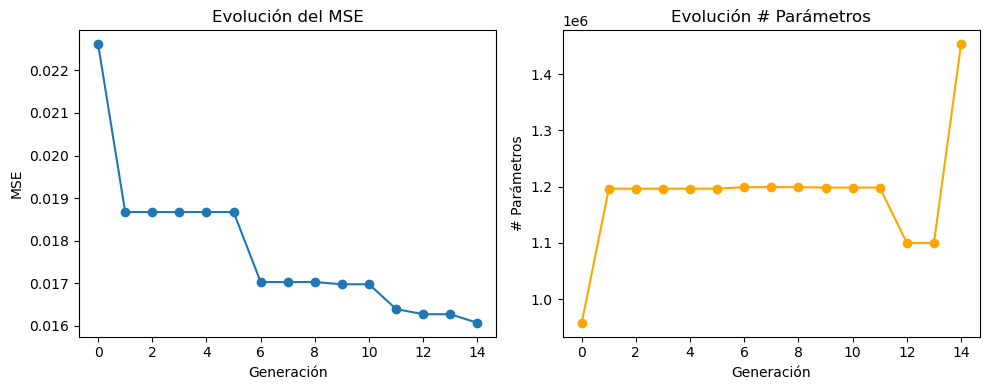

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(mse_lst, marker='o')
plt.title('Evolución del MSE')
plt.xlabel('Generación')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(param_count_lst, marker='o', color='orange')
plt.title('Evolución # Parámetros')
plt.xlabel('Generación')
plt.ylabel('# Parámetros')

plt.tight_layout()
plt.show()